<a href="https://colab.research.google.com/github/ALU-AIIP-18/Group_A_Capstone/blob/main/C__Users_Adrian_Dropbox_AIIP_d4I_summative_summative_assign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://stateimpact.npr.org/texas/files/2012/01/solar-cropped.jpg" >
<h1><center> Edwards Pharmacy Exploratory Data Analysis & Condition Monitoring <center><h1>

**The Objectives**

 
1. Can we use the digital twin to study output of plant and compare to ideal?
2. Can we use the digital twin to predict the power generation for next few days?
2. Can we identify faulty or suboptimally performing equipment?




**The Components**



*   Physical Asset: 2 weeks data from a plant in SA
*   Digital Twin : Analysis and Deductions from PV Lib
*   Physical Asset II :Deductions and display






<a id="section-one"></a>
# 1. Introduction

This notebook presents a layout of the scripts that will go into making the digital twin. The process involves undertaking web scrapping to obtain 12 day operational data from a real solar power plant in South Africa, obtained from the PVout website; a website that aggregates live data from real pv systems around the world. This data shall constitute the physical asse. The work shall then seek to leverage the availability of equipmnent data and the pvlib solar pv library to undertake taks that will meet the aforementioned objectives.


## 1.1 Solar Power- A summary

Solar pv plants make us of the photovoltaic effect, where photon absorption leads to injection of excited electrons into the conduction band. This leads to the generation of Dc power. The Dc power is subsequently converted to ac power using inveters. Aside from the solar pv modules themselves, weather and climate play an important role in predicting solar pv output. Some important parameters include: irradiance, ambient temperature and cloud cover. By accessing weather APis, it is possbile to undertake major tasks on solar pv data; including forecasting, predicting outpu and analysing anomalies. 

## 1.2 Dataset Description
The the data contains 2 week data from a grid-tied solar power plant named "Edward's Pharmacy in South Africa coordinates <a style="font-weight:bold" href="https://www.google.com/maps/place/28%C2%B053'37.0%22S+31%C2%B028'05.9%22E/@-28.8935958,31.4677458,204m/data=!3m2!1e3!4b1!4m2!3m1!1s0x0:0x0"> (-28.893597,31.468293)</a> .The data is sampled every 5 minutes, and sent to the <a style="font-weight:bold" href="https://pvoutput.org/display.jsp?sid=45346"> pvout website</a> .The dataset contains the following information:

- Date and Time
- Power and energy i.e geenrated and consumed
- Ambient temperature

The wesbite has an API key that only works if one has a system linked to the website. As such, a decision was made to obtain the dataset through webscrapping.

## 1.3 The objectives
- Can we use the digital twin to study output of plant and compare to ideal?
- Can we use the digital twin to predict the power generation for next few days?
- Can we identify faulty or suboptimally performing equipment?

## 1.4 The Approach

**Physical Asset- Script 1**
- Webscrapping to obtain physical asset data.
- Pre-process the data and generate a pandas dataframe. The entire script will be wrapped in a module for import to the "digital twin"

**Digital Twin- Script 2**
- Model output of digital twin and compare to similar dates in the past for physical asset, in order to evaluate performance, and inform on best tilt angle
- Use linear regression to identify anomalies in generation data, and predict outages, shading, overloads.
- Use pvlib library and equipment data to forecast for next few days

**Physical Asset- Script 3**
- Simulate Communication by visualising outputs from digital twin




## **Physical Twin**

In [237]:
import requests # for making standard html requests
from bs4 import BeautifulSoup #l tool for parsing html data
import json # for parsing json data
import pandas as pd





In [249]:
# The daily data is stored in data tables on the website which are differentiated by the 'dt' tag at the end, which contains the date
# See here https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201110
# The process below generates dates starting from today going backwards 12 days, and add the date to the 'dt' tag

#import date utils
from datetime import date, timedelta

#subtract 12 days
dt = date.today() - timedelta(12)
lst={d.strftime('%Y%m%d') for d in pd.date_range(dt,date.today())}

#the base url address with a blank 'dt' tag that will be egenrate from a loop
url_test = 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=%s'

# List comprehension to geenrate urls
urls=[url_test %i for i in lst]
urls.sort(key=lambda url: url.split('/')[-1], reverse=False)
urls

['https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201105',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201106',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201107',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201108',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201109',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201110',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201111',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201112',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201113',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201114',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201115',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201116',
 'https://pvoutput.org/intraday.jsp?id=49819&sid=45346&dt=20201117']

In [239]:
#generate pages usign requests
pages=[requests.get(j)for j in urls]

#use beautiful soup to parse html
soups=[BeautifulSoup(page.text, 'html.parser') for page in pages]


In [240]:
# This workflow extracts data from the datatables and generates a list of dataframes, one for each day
tables=[soup.find('table',id='tb') for soup in soups]

table_rows = [table.find_all('tr') for table in tables]


rests=[]
for table_row in table_rows:
  res=[]
  for tr in table_row:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
  rests.append(res)

# Generate list of dataframes
dfs = [pd.DataFrame(i, columns=['Date','Time','Energy(kWh)','Efficiency(kWh/kW)','Power(W)','Average(W)',
      'Normalised(kW/kW)','Temperature(C)','Voltage(V)','Energy Used(kWh)','Power Used(W)']) for i in rests ]
#Remove first row which picked erroneous data
dfs=[df[1:] for df in dfs]         


# Concatenate list of dataframes into single df
data=pd.concat(dfs)


# Preprocessign data
# Removes "W", 'kWh' labels and thousand separator commas
data['Energy(kWh)'] = data['Energy(kWh)'].str.replace('kWh', '')
data['Efficiency(kWh/kW)'] = data['Efficiency(kWh/kW)'].str.replace('kWh/kW', '')
data['Power(W)'] = data['Power(W)'].str.replace('W', '').str.replace(',', '')

data['Average(W)'] = data['Average(W)'].str.replace('W', '')
data['Normalised(kW/kW)'] = data['Normalised(kW/kW)'].str.replace('kW/kW', '')
data['Temperature(C)'] = data['Temperature(C)'].str.replace('C', '')

# data['Voltage(V)'] = data['Voltage(V)'].str.replace('-', 0)
data['Energy Used(kWh)'] = data['Energy Used(kWh)'].str.replace('kWh', '')
data['Power Used(W)'] = data['Power Used(W)'].str.replace('W', '').str.replace(',', '')

#Combine Date and Time Columns and convert to Datetime
data['Time']= pd.to_datetime(data['Time']).dt.strftime('%H:%M:%S')
data['Datetime'] =pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.drop(['Date','Time'],axis=1,inplace=True)
# data['Datetime']=data['Datetime'].apply(lambda x: x.strftime('%d%m%Y %H:%M:%S'))
#data['Datetime']=pd.to_datetime(data['Datetime'])#.apply(str)+' '+data['Time'],format='%d/%m/%y %H:%M:%S')
# cols=data.columns.drop(['Date','Time'])
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
# data = data.drop(['Date','Time'], axis=1)

#Reorder Columns
data=data[['Datetime','Energy(kWh)', 'Efficiency(kWh/kW)', 'Power(W)', 'Average(W)',
       'Normalised(kW/kW)', 'Temperature(C)', 'Voltage(V)', 'Energy Used(kWh)',
       'Power Used(W)']]



In [241]:
data.dtypes

Datetime              datetime64[ns]
Energy(kWh)                  float64
Efficiency(kWh/kW)           float64
Power(W)                       int64
Average(W)                   float64
Normalised(kW/kW)            float64
Temperature(C)               float64
Voltage(V)                    object
Energy Used(kWh)             float64
Power Used(W)                  int64
dtype: object

In [242]:
data.tail()

,Datetime,Energy(kWh),Efficiency(kWh/kW),Power(W),Average(W),Normalised(kW/kW),Temperature(C),Voltage(V),Energy Used(kWh),Power Used(W)
97,2020-11-17 00:40:00,NaN,NaN,0,NaN,NaN,19.4,-,0.998,1336
98,2020-11-17 00:30:00,NaN,NaN,0,NaN,NaN,19.4,-,0.776,1310
99,2020-11-17 00:20:00,NaN,NaN,0,NaN,NaN,19.4,-,0.557,1334
100,2020-11-17 00:10:00,NaN,NaN,0,NaN,NaN,19.4,-,0.335,1341
101,2020-11-17 00:00:00,NaN,NaN,0,NaN,NaN,NaN,-,0.000,1336


In [243]:
data.isnull().sum(axis=0)

Datetime                 0
Energy(kWh)             30
Efficiency(kWh/kW)      30
Power(W)                 0
Average(W)            1517
Normalised(kW/kW)       43
Temperature(C)          26
Voltage(V)               0
Energy Used(kWh)         0
Power Used(W)            0
dtype: int64

In [244]:
# Drop values where temperature is null
# For other values fill null with zero ...there's no power output at night
# Drop Voltage column since it has not values
data['Energy(kWh)']= data['Energy(kWh)'].fillna(0)
data = data[data['Temperature(C)'].notna()]
data.drop('Voltage(V)',axis=1,inplace=True)
data=data.fillna(0)

In [245]:
data.isnull().sum(axis=0)

Datetime              0
Energy(kWh)           0
Efficiency(kWh/kW)    0
Power(W)              0
Average(W)            0
Normalised(kW/kW)     0
Temperature(C)        0
Energy Used(kWh)      0
Power Used(W)         0
dtype: int64

In [246]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Energy(kWh),3157.0,29.921177,31.518326,0.0,0.401,14.769,53.428,92.041
Efficiency(kWh/kW),3157.0,1.955637,2.060039,0.0,0.026,0.965,3.492,6.016
Power(W),3157.0,2532.563510,3702.668571,0.0,0.000,929.000,3750.000,13517.000
Average(W),3157.0,62.875515,227.569282,0.0,0.000,0.000,0.000,996.000
Normalised(kW/kW),3157.0,0.165520,0.242007,0.0,0.000,0.060,0.245,0.883
Temperature(C),3157.0,20.498036,4.605720,13.9,16.100,19.400,23.300,36.700
Energy Used(kWh),3157.0,62.145099,63.303289,0.0,7.047,33.791,106.641,223.651
Power Used(W),3157.0,5582.772886,7181.073961,0.0,1192.000,1330.000,8728.000,30855.000


## **Digital Twin**

## Physical data

The meaning of the data columsn is offered below:

- Energy(kWh): cumulative solar energy output from beginning of day till the particular time
- Efficiency(kWh/kW): Amount of energy generated divided by the system size
- Power(W): Maximum Ac output for the interval
- Average(W): Total pv energy divided by time
- Normalised(kW/kW): Peak Power divided by expected PV power.
- Temperature(C): Ambient temperature
- Energy Used(kWh): Total energy used by user i.e solar generation less grid infeed
- Power Used(W): Peak Power Used by user

In [163]:
# !pip install pvlib


In [164]:
# !pip install netCDF4
# !pip install siphon

In [185]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

from pvlib import solarposition, irradiance, atmosphere, pvsystem, inverter, temperature
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR
import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')


#### correlation

In [ ]:
data.columns

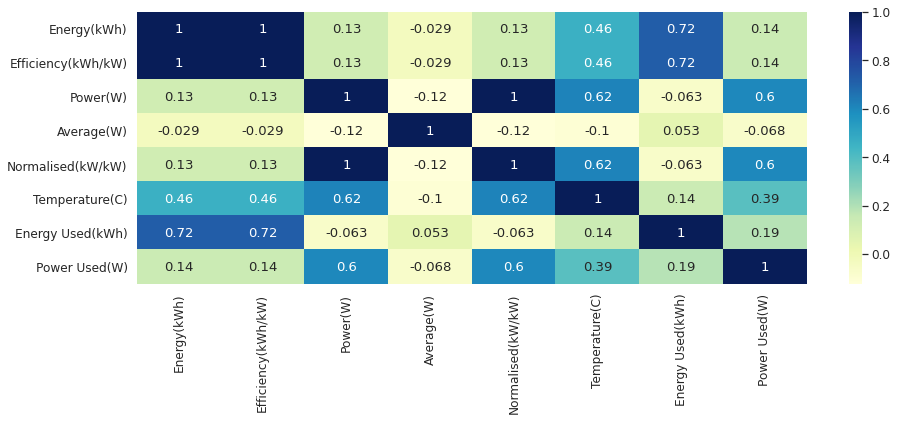

In [178]:
cols= ['Energy(kWh)', 'Efficiency(kWh/kW)', 'Power(W)',
       'Average(W)', 'Normalised(kW/kW)', 'Temperature(C)', 'Energy Used(kWh)',
       'Power Used(W)']
corrMatrix = data[cols].corr()
plt.figure(figsize=(15,5))
fig_corr = sns.heatmap(corrMatrix,cmap="YlGnBu", annot=True)
plt.show()

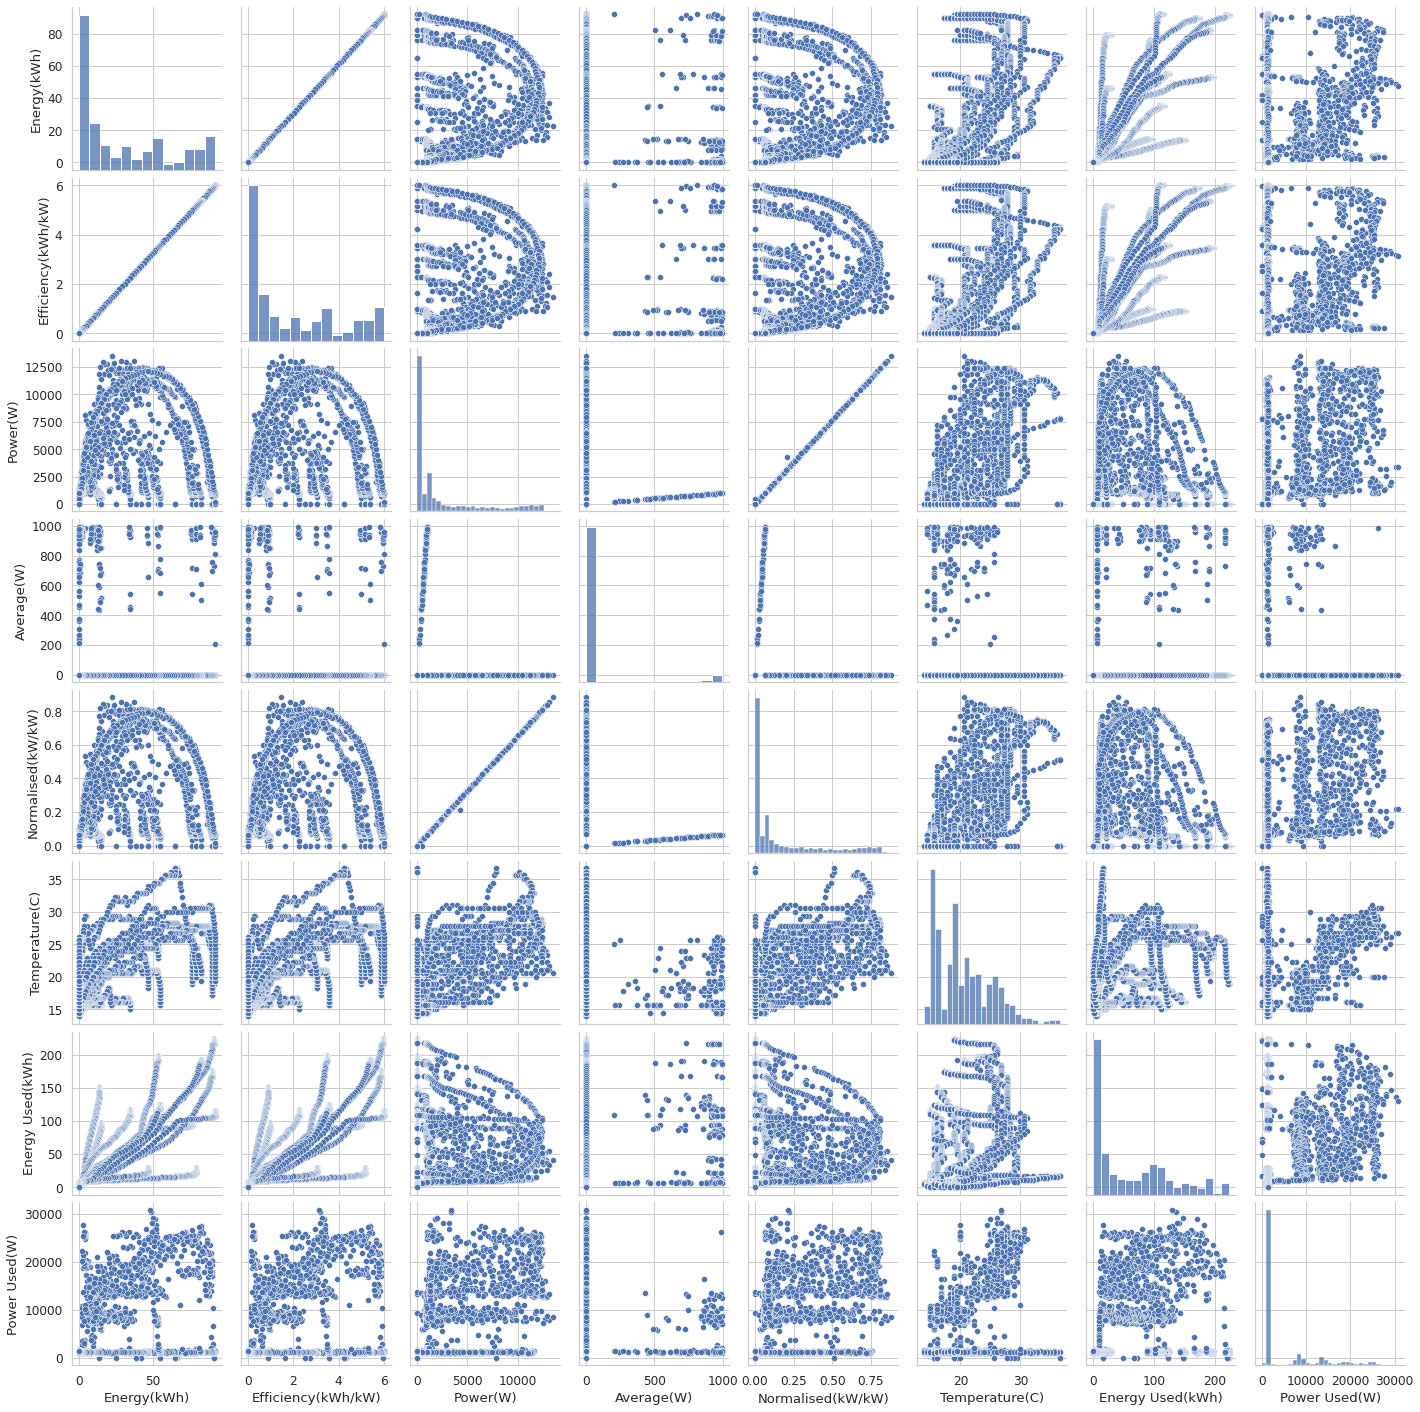

In [181]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [6, 5]})

fig_pair = sns.pairplot(data[cols])
plt.show()

In [182]:
data.columns

Index(['Datetime', 'Energy(kWh)', 'Efficiency(kWh/kW)', 'Power(W)',
       'Average(W)', 'Normalised(kW/kW)', 'Temperature(C)', 'Energy Used(kWh)',
       'Power Used(W)'],
      dtype='object')

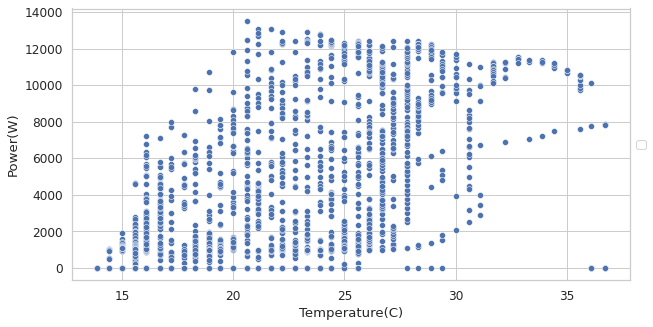

In [188]:
plt.figure(figsize=(10,5))
fig_power = sns.scatterplot(data=data, x="Temperature(C)", y="Power(W)", palette="tab10")
fig_power.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

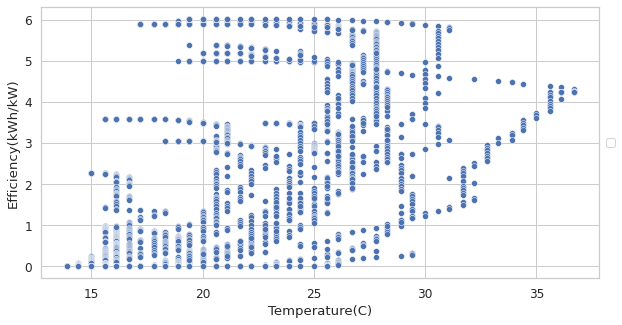

In [186]:
plt.figure(figsize=(10,5))
fig_power = sns.scatterplot(data=data, x="Temperature(C)", y="Efficiency(kWh/kW)", palette="tab10")
fig_power.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

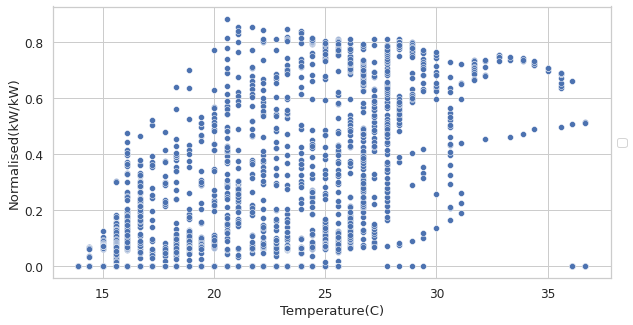

In [187]:
plt.figure(figsize=(10,5))
fig_power = sns.scatterplot(data=data, x="Temperature(C)", y="Normalised(kW/kW)", palette="tab10")
fig_power.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

### PVlib Weather "Forecast" for previous X days

In [200]:
# Choose a location.
# Eshowe,ZA

latitude = -28.893597
longitude = 31.468293
tz ='Africa/Johannesburg'

Define some PV system parameters.

In [201]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

In [226]:
# start = pd.Timestamp(datetime.date.today(), tz=tz) # today's date
# end = start + pd.Timedelta(days=7) # 7 days from today

#subtract 12 days
end=pd.Timestamp(datetime.date.today(), tz=tz) 
start = end - timedelta(12)


In [227]:
# Define forecast model
fm = GFS()
#fm = NAM()
#fm = NDFD()
#fm = RAP()
#fm = HRRR()

In [228]:
# Retrieve data
previous_forecast = fm.get_processed_data(latitude, longitude, start, end)


In [262]:

# previous_forecast.head()

In [258]:
# physical_dat=data.copy()
# physical_dat['Datetime']=physical_dat['Datetime']
# physical_dat = physical_dat.set_index('Datetime').resample('3H').mean()

# physical_dat.index=physical_dat.index.tz_localize(tz) 

In [259]:
physical_dat.head()

,Energy(kWh),Efficiency(kWh/kW),Power(W),Average(W),Normalised(kW/kW),Temperature(C),Energy Used(kWh),Power Used(W)
Datetime,,,,,,,,
2020-05-11 00:00:00+02:00,0.000000,0.000000,0.000000,0.000000,0.000000,19.313889,1.870278,1279.444444
2020-05-11 03:00:00+02:00,0.097222,0.006333,243.916667,126.666667,0.015944,18.366667,5.651750,1254.361111
2020-05-11 06:00:00+02:00,6.133000,0.400806,4859.777778,0.000000,0.317639,21.766667,14.272639,7593.472222
2020-05-11 09:00:00+02:00,27.311944,1.785139,8397.416667,0.000000,0.548861,25.880556,55.234833,16778.638889
2020-05-11 12:00:00+02:00,43.669417,2.854222,2387.361111,0.000000,0.156028,25.361111,105.193417,16226.916667


In [260]:
# df_merged = previous_forecast.merge(physical_dat, how='outer', left_index=True, right_index=True)

In [261]:
# df_merged.head()

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds,Energy(kWh),Efficiency(kWh/kW),Power(W),Average(W),Normalised(kW/kW),Temperature(C),Energy Used(kWh),Power Used(W)
2020-05-11 00:00:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,19.313889,1.870278,1279.444444
2020-05-11 03:00:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097222,0.006333,243.916667,126.666667,0.015944,18.366667,5.651750,1254.361111
2020-05-11 06:00:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.133000,0.400806,4859.777778,0.000000,0.317639,21.766667,14.272639,7593.472222
2020-05-11 09:00:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.311944,1.785139,8397.416667,0.000000,0.548861,25.880556,55.234833,16778.638889
2020-05-11 12:00:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.669417,2.854222,2387.361111,0.000000,0.156028,25.361111,105.193417,16226.916667


In [199]:
# from pvlib.pvsystem import PVSystem, retrieve_sam

# from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

# from pvlib.tracking import SingleAxisTracker

# from pvlib.modelchain import ModelChain

# sandia_modules = retrieve_sam('sandiamod')

# cec_inverters = retrieve_sam('cecinverter')

# module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

# inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']

# temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# # model a big tracker for more fun
# system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# # fx is a common abbreviation for forecast
# fx_model = GFS()

# fx_data = fx_model.get_processed_data(latitude, longitude, start, end)

# # use a ModelChain object to calculate modeling intermediates
# mc = ModelChain(system, fx_model.location)

# # extract relevant data for model chain
# mc.run_model(fx_data);

NameError: ignored